Using: cuda
Length of Train Data : 3000
Length of Validation Data : 513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


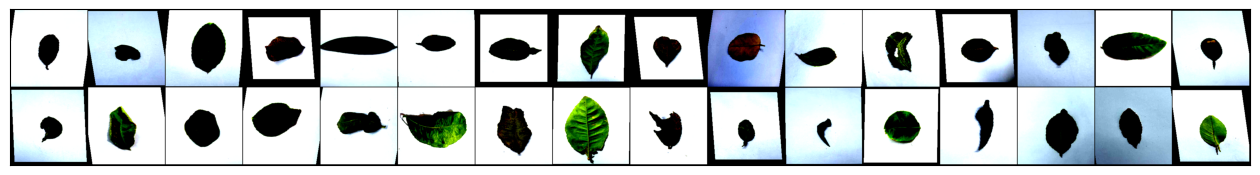

In [1]:
from datasetup import *

In [2]:
from resnet50 import *
from densenet121 import *
from efficientnetb0 import *
from mobilenetv2 import *

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-dat

In [3]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import torch
import torch.nn.functional as F

In [4]:
def plot_history(history):
    plt.figure(figsize=(18, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history["val_f1"], label="Val F1", color='purple')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Curve")
    plt.legend()

    
    plt.tight_layout()
    plt.show()


In [5]:
def eval_plot(y_true, y_pred, class_names=["Healthy", "Unhealthy"]):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    print("Confusion Matrix:\n", conf_matrix)
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix Heatmap")
    plt.show()


In [6]:
from sklearn.metrics import roc_curve, auc

def plot_final_roc(model, dataloader, modelname):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # get class-1 probs

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("Final ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    graph_path = f'./plots/{modelname}_roc.png'
    plt.savefig(graph_path)


In [17]:
def train(model, criterion, optimizer, num_epochs=1, patience=3, save_path="./best_model.pth"):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for phase in ["train", "test"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0
            y_true, y_pred = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            if phase == "test":
                f1 = f1_score(y_true, y_pred)
                history["val_f1"].append(f1)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), save_path)
                    print("Best model saved.")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epoch(s).")

                if epochs_no_improve >= patience:
                    print("Early stopping.")
                    model.load_state_dict(best_model_wts)
                    return model, history, y_true, y_pred

            print(f"{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history, y_true, y_pred

In [13]:
def get_probs_and_labels(model, dataloader):
    model.eval()
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Get P(class=1)
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())
    
    return y_true, y_scores

def plot_combined_roc(models_info, dataloader):
    """
    models_info: list of tuples (label_string, model_object)
    """
    plt.figure(figsize=(8, 6))
    
    for label, model in models_info:
        y_true, y_scores = get_probs_and_labels(model, dataloader)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
import matplotlib.pyplot as plt

def plot_all_f1_curves(all_histories):
    plt.figure(figsize=(10, 6))

    for model_name, history in all_histories.items():
        if "val_f1" in history:
            epochs = range(1, len(history["val_f1"]) + 1)
            plt.plot(epochs, history["val_f1"], label=model_name)

    plt.xlabel("Epoch")
    plt.ylabel("Validation F1 Score")
    plt.title("Validation F1 Score Across Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
models_info = [
    ("DenseNet121", densenet_model),
    ("MobileNetV2", mobilenet_model),
    ("EfficientNetB0", efficientnet_model),
    ("ResNet50", resnet_model)
]

all_histories = {
    "DenseNet121": [],
    "MobileNetV2": [],
    "EfficientNetB0": [],
    "ResNet50": []
}

for name, model in models_info:
    model = model.to(device)
    if name == "DenseNet121":
        model, all_histories["DenseNet121"], y_true, y_pred = train(model, criterion_den, optimizer_den, num_epochs=10, patience=3, save_path = f'./{name}_model')
    elif name == "MobileNetV2":
        model, all_histories["MobileNetV2"], y_true, y_pred = train(model, criterion_mob, optimizer_mob, num_epochs=10, patience=3, save_path = f'./{name}_model')
    elif name == "EfficientNetB0":
        model, all_histories["EfficientNetB0"], y_true, y_pred = train(model, criterion_eff, optimizer_eff, num_epochs=10, patience=3, save_path = f'./{name}_model')        
    else:
        model, all_histories["ResNet50"], y_true, y_pred = train(model, criterion_res, optimizer_res, num_epochs=10, patience=3, save_path = f'./{name}_model')
        


#plot_combined_roc(models_info, dataloaders['test'])
#eval_plot(y_true, y_pred)
#plot_final_roc(model, dataloaders["test"], "efficientnetB0")


train loss: 0.2750, acc: 0.8873
best model saved
test loss: 0.2077, acc: 0.9201
train loss: 0.2560, acc: 0.8930
 No improvement for 1 epoch(s).
test loss: 0.2279, acc: 0.9181
train loss: 0.2348, acc: 0.8960
 No improvement for 2 epoch(s).
test loss: 0.2859, acc: 0.9513
train loss: 0.2737, acc: 0.8813
 No improvement for 3 epoch(s).
Early stopping
train loss: 0.2543, acc: 0.8897
best model saved
test loss: 0.2601, acc: 0.9201
train loss: 0.2428, acc: 0.8960
 No improvement for 1 epoch(s).
test loss: 0.2658, acc: 0.8635
train loss: 0.2274, acc: 0.8973
best model saved
test loss: 0.1912, acc: 0.9103
train loss: 0.2201, acc: 0.9117
 No improvement for 1 epoch(s).
test loss: 0.2066, acc: 0.9259
train loss: 0.2123, acc: 0.9070
 No improvement for 2 epoch(s).
test loss: 0.2069, acc: 0.9006
train loss: 0.2444, acc: 0.8950
 No improvement for 3 epoch(s).
Early stopping
train loss: 0.2473, acc: 0.8950
best model saved
test loss: 0.2441, acc: 0.8928
train loss: 0.2521, acc: 0.8847
best model save

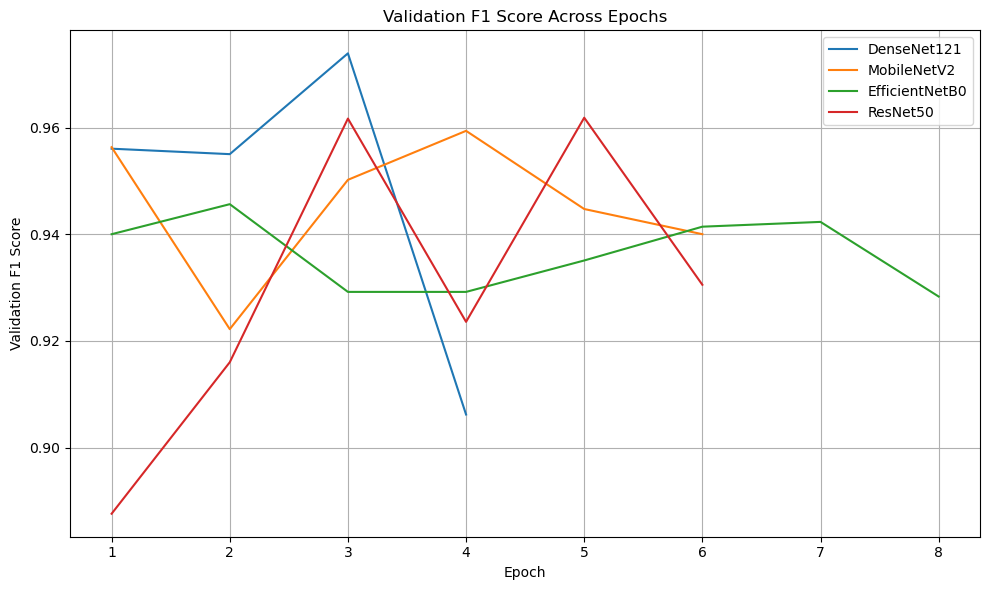

In [16]:
plot_all_f1_curves(all_histories)